## In this notebook

- Comparison of libraries.

In [1]:
from pathlib import Path

import duckdb
import numpy as np
import pandas as pd
import polars as pl

In [2]:
DATA_PATH = Path("/usr/src/app/data/palmer_penguins.csv")

## Compare package size

In [3]:
# package size

for package in ["pandas", "polars", "duckdb"]:
    
    package_location = f"/opt/venv/lib/python3.10/site-packages/{package}"
    
    ! du -sh $package_location

80M	/opt/venv/lib/python3.10/site-packages/pandas
87M	/opt/venv/lib/python3.10/site-packages/polars
51M	/opt/venv/lib/python3.10/site-packages/duckdb


## pandas

In [4]:
df = pd.read_csv(
    filepath_or_buffer=DATA_PATH,
)

print(df)

    pinguin_id        date species  bill_length  bill_depth     sex
0         N1A1  2007-11-11  adelie         39.1        18.7    MALE
1         N1A2  2007-11-11  adelie         39.5        17.4  FEMALE
2         N2A1  2007-11-16  adelie         40.3        18.0  FEMALE
3         N2A2  2007-11-16  adelie          NaN         NaN     NaN
4         N3A1  2007-11-16  adelie         36.7        19.3  FEMALE
..         ...         ...     ...          ...         ...     ...
339      N38A2  2009-12-01  gentoo          NaN         NaN     NaN
340      N39A1  2009-11-22  gentoo         46.8        14.3  FEMALE
341      N39A2  2009-11-22  gentoo         50.4        15.7    MALE
342      N43A1  2009-11-22  gentoo         45.2        14.8  FEMALE
343      N43A2  2009-11-22  gentoo         49.9        16.1    MALE

[344 rows x 6 columns]


In [5]:
print(
    df
    .assign(
        sex=lambda _df: _df.sex.str.lower(),
    )
    .groupby(by="species")
    .agg(
        samples_cnt=("pinguin_id", "count"),
        male_cnt=("sex", lambda x: x[x == "male"].count()),
        bill_length_avg=("bill_length", "mean"),
    )
    .round(1)
)

           samples_cnt  male_cnt  bill_length_avg
species                                          
adelie             152        73             38.8
chinstrap           68        34             48.8
gentoo             124        61             47.5


In [6]:
# convert string to datetime
df["date"] = pd.to_datetime(df.date)

# get unique sample dates from year 2007
unique_dates_2007 = (
    df
    .date
    .loc[df.date.dt.year == 2007]
    .drop_duplicates()
    .sort_values()
    .reset_index(drop=True)
)

# get the difference between sample days
print(unique_dates_2007 - unique_dates_2007.shift())

0       NaT
1    1 days
2    1 days
3    1 days
4    1 days
5    2 days
6    1 days
7    2 days
8    1 days
9    2 days
10   1 days
11   4 days
12   1 days
13   1 days
14   1 days
15   1 days
16   3 days
Name: date, dtype: timedelta64[ns]


<Axes: title={'center': 'Bill length vs bill depth'}, xlabel='Bill length (mm)', ylabel='Bill depth (mm)'>

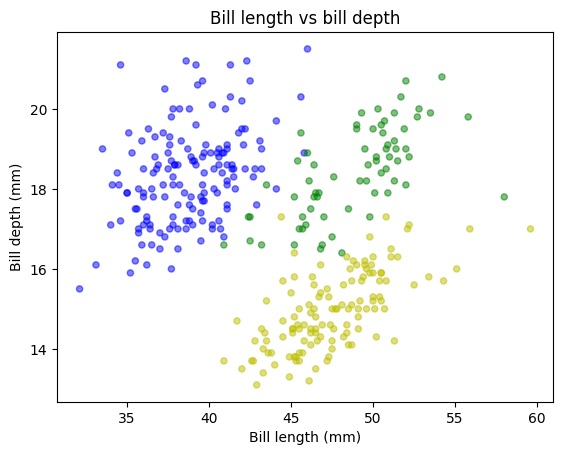

In [7]:
(
    df
    .plot(
        kind="scatter",
        x="bill_length",
        y="bill_depth",
        color=df.species.map({
            "adelie": "b", 
            "chinstrap": "g", 
            "gentoo": "y",
        }),
        alpha=0.5,
        xlabel="Bill length (mm)", 
        ylabel="Bill depth (mm)", 
        title="Bill length vs bill depth",
    )
)

## polars

In [8]:
df = pl.read_csv(
    source=DATA_PATH
)

print(df)

shape: (344, 6)
┌────────────┬────────────┬─────────┬─────────────┬────────────┬────────┐
│ pinguin_id ┆ date       ┆ species ┆ bill_length ┆ bill_depth ┆ sex    │
│ ---        ┆ ---        ┆ ---     ┆ ---         ┆ ---        ┆ ---    │
│ str        ┆ str        ┆ str     ┆ f64         ┆ f64        ┆ str    │
╞════════════╪════════════╪═════════╪═════════════╪════════════╪════════╡
│ N1A1       ┆ 2007-11-11 ┆ adelie  ┆ 39.1        ┆ 18.7       ┆ MALE   │
│ N1A2       ┆ 2007-11-11 ┆ adelie  ┆ 39.5        ┆ 17.4       ┆ FEMALE │
│ N2A1       ┆ 2007-11-16 ┆ adelie  ┆ 40.3        ┆ 18.0       ┆ FEMALE │
│ N2A2       ┆ 2007-11-16 ┆ adelie  ┆ null        ┆ null       ┆ null   │
│ N3A1       ┆ 2007-11-16 ┆ adelie  ┆ 36.7        ┆ 19.3       ┆ FEMALE │
│ …          ┆ …          ┆ …       ┆ …           ┆ …          ┆ …      │
│ N38A2      ┆ 2009-12-01 ┆ gentoo  ┆ null        ┆ null       ┆ null   │
│ N39A1      ┆ 2009-11-22 ┆ gentoo  ┆ 46.8        ┆ 14.3       ┆ FEMALE │
│ N39A2      ┆ 2009-11

In [9]:
# missing values

print(
    df
    .with_columns(
        bill_depth_int=pl.col("bill_depth").cast(pl.Int64),
        missing_values=None,
    )
    .select("pinguin_id", "bill_depth", "bill_depth_int", "missing_values")
    .head()
)

shape: (5, 4)
┌────────────┬────────────┬────────────────┬────────────────┐
│ pinguin_id ┆ bill_depth ┆ bill_depth_int ┆ missing_values │
│ ---        ┆ ---        ┆ ---            ┆ ---            │
│ str        ┆ f64        ┆ i64            ┆ null           │
╞════════════╪════════════╪════════════════╪════════════════╡
│ N1A1       ┆ 18.7       ┆ 18             ┆ null           │
│ N1A2       ┆ 17.4       ┆ 17             ┆ null           │
│ N2A1       ┆ 18.0       ┆ 18             ┆ null           │
│ N2A2       ┆ null       ┆ null           ┆ null           │
│ N3A1       ┆ 19.3       ┆ 19             ┆ null           │
└────────────┴────────────┴────────────────┴────────────────┘


In [10]:
# missing values -- pandas

(
    df
    .to_pandas()
    .assign(
        missing_values=None,
    )
)

,pinguin_id,date,species,bill_length,bill_depth,sex,missing_values
0,N1A1,2007-11-11,adelie,39.1,18.7,MALE,None
1,N1A2,2007-11-11,adelie,39.5,17.4,FEMALE,None
2,N2A1,2007-11-16,adelie,40.3,18.0,FEMALE,None
3,N2A2,2007-11-16,adelie,NaN,NaN,None,None
4,N3A1,2007-11-16,adelie,36.7,19.3,FEMALE,None
...,...,...,...,...,...,...,...
339,N38A2,2009-12-01,gentoo,NaN,NaN,None,None
340,N39A1,2009-11-22,gentoo,46.8,14.3,FEMALE,None
341,N39A2,2009-11-22,gentoo,50.4,15.7,MALE,None
342,N43A1,2009-11-22,gentoo,45.2,14.8,FEMALE,None


In [11]:
%%time

# eager execution

print(
    pl
    .read_csv(DATA_PATH)
    .group_by("species")
    .agg(
        pl.col("bill_length").mean(),
        pl.col("bill_depth").mean(),
    )
)

shape: (3, 3)
┌───────────┬─────────────┬────────────┐
│ species   ┆ bill_length ┆ bill_depth │
│ ---       ┆ ---         ┆ ---        │
│ str       ┆ f64         ┆ f64        │
╞═══════════╪═════════════╪════════════╡
│ chinstrap ┆ 48.833824   ┆ 18.420588  │
│ adelie    ┆ 38.791391   ┆ 18.346358  │
│ gentoo    ┆ 47.504878   ┆ 14.982114  │
└───────────┴─────────────┴────────────┘
CPU times: user 2.03 ms, sys: 1.95 ms, total: 3.98 ms
Wall time: 1.52 ms


In [12]:
%%time

# lazy execution

print(
    pl
    .scan_csv(DATA_PATH)
    .group_by("species")
    .agg(
        pl.col("bill_length").mean(),
        pl.col("bill_depth").mean(),
    )
    .collect()
)

shape: (3, 3)
┌───────────┬─────────────┬────────────┐
│ species   ┆ bill_length ┆ bill_depth │
│ ---       ┆ ---         ┆ ---        │
│ str       ┆ f64         ┆ f64        │
╞═══════════╪═════════════╪════════════╡
│ chinstrap ┆ 48.833824   ┆ 18.420588  │
│ gentoo    ┆ 47.504878   ┆ 14.982114  │
│ adelie    ┆ 38.791391   ┆ 18.346358  │
└───────────┴─────────────┴────────────┘
CPU times: user 3.99 ms, sys: 1.06 ms, total: 5.05 ms
Wall time: 2.06 ms


In [13]:
# sequential vs parallel operations

df.with_columns(
    # bill length
    bill_length_nm=pl.col("bill_length") * 1e+6,
    bill_length_um=pl.col("bill_length") * 1e+3,
    bill_length_mm=pl.col("bill_length"),
    bill_length_m=pl.col("bill_length") * 1e-3,
    bill_length_km=pl.col("bill_length") * 1e-6,
    
    # bill depth
    bill_depth_nm=pl.col("bill_depth") * 1e+6,
    bill_depth_um=pl.col("bill_depth") * 1e+3,
    bill_depth_mm=pl.col("bill_depth"),
    bill_depth_m=pl.col("bill_depth") * 1e-3,
    bill_depth_km=pl.col("bill_depth") * 1e-6,
).head()

pinguin_id,date,species,bill_length,bill_depth,sex,bill_length_nm,bill_length_um,bill_length_mm,bill_length_m,bill_length_km,bill_depth_nm,bill_depth_um,bill_depth_mm,bill_depth_m,bill_depth_km
str,str,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""N1A1""","""2007-11-11""","""adelie""",39.1,18.7,"""MALE""",3.91e7,39100.0,39.1,0.0391,0.0000391,1.87e7,18700.0,18.7,0.0187,0.000019
"""N1A2""","""2007-11-11""","""adelie""",39.5,17.4,"""FEMALE""",3.95e7,39500.0,39.5,0.0395,0.0000395,1.74e7,17400.0,17.4,0.0174,0.0000174
"""N2A1""","""2007-11-16""","""adelie""",40.3,18.0,"""FEMALE""",4.03e7,40300.0,40.3,0.0403,0.0000403,1.8e7,18000.0,18.0,0.018,0.000018
"""N2A2""","""2007-11-16""","""adelie""",null,null,null,null,null,null,null,null,null,null,null,null,null
"""N3A1""","""2007-11-16""","""adelie""",36.7,19.3,"""FEMALE""",3.67e7,36700.0,36.7,0.0367,0.000037,1.93e7,19300.0,19.3,0.0193,0.000019


In [14]:
(
    df
    .plot
    .scatter(
        x="bill_length", 
        y="bill_depth", 
        by="species",
        alpha=0.5,
        xlabel="Bill length (mm)",
        ylabel="Bill depth (mm)",
        title="Bill length vs bill depth",
    )
)

:NdOverlay   [species]
   :Scatter   [bill_length]   (bill_depth)

## duckdb

*Compute the **average bill size** of **male** penguins for every species.*

In [15]:
data_raw = (
    duckdb
    .read_csv(name=DATA_PATH)
    .select("species", "bill_length", "bill_depth", "sex")
)

data_raw

┌─────────┬─────────────┬────────────┬─────────┐
│ species │ bill_length │ bill_depth │   sex   │
│ varchar │   double    │   double   │ varchar │
├─────────┼─────────────┼────────────┼─────────┤
│ adelie  │        39.1 │       18.7 │ MALE    │
│ adelie  │        39.5 │       17.4 │ FEMALE  │
│ adelie  │        40.3 │       18.0 │ FEMALE  │
│ adelie  │        NULL │       NULL │ NULL    │
│ adelie  │        36.7 │       19.3 │ FEMALE  │
│ adelie  │        39.3 │       20.6 │ MALE    │
│ adelie  │        38.9 │       17.8 │ FEMALE  │
│ adelie  │        39.2 │       19.6 │ MALE    │
│ adelie  │        34.1 │       18.1 │ NULL    │
│ adelie  │        42.0 │       20.2 │ NULL    │
│   ·     │          ·  │         ·  │  ·      │
│   ·     │          ·  │         ·  │  ·      │
│   ·     │          ·  │         ·  │  ·      │
│ gentoo  │        46.2 │       14.1 │ FEMALE  │
│ gentoo  │        55.1 │       16.0 │ MALE    │
│ gentoo  │        44.5 │       15.7 │ .       │
│ gentoo  │        4

### SQL syntax

In [16]:
cleaned = duckdb.sql(query="""
    select 
        species,
        lower(sex) as sex,
        bill_length,
        bill_depth
    from data_raw
    where sex is not null
""")

agg = duckdb.sql(query="""
    select
        species,
        avg(bill_length)::int as bill_length_avg,
        avg(bill_depth)::int as bill_depth_avg
    from cleaned
    where sex = 'male'
    group by species
    order by species
""")

duckdb.sql(query="select * from agg")

┌───────────┬─────────────────┬────────────────┐
│  species  │ bill_length_avg │ bill_depth_avg │
│  varchar  │      int32      │     int32      │
├───────────┼─────────────────┼────────────────┤
│ adelie    │              40 │             19 │
│ chinstrap │              51 │             19 │
│ gentoo    │              49 │             16 │
└───────────┴─────────────────┴────────────────┘

### SQL syntax using CTE

In [17]:
duckdb.sql(query=f"""
    with cleaned as (
        select 
            species,
            lower(sex) as sex,
            bill_length,
            bill_depth
        from data_raw
        where sex is not null
    ),
    
    agg as (
        select
            species,
            avg(bill_length)::int as bill_length_avg,
            avg(bill_depth)::int as bill_depth_avg
        from cleaned
        where sex = 'male'
        group by species
        order by species
    )
    
    select * from agg;
    """
)

┌───────────┬─────────────────┬────────────────┐
│  species  │ bill_length_avg │ bill_depth_avg │
│  varchar  │      int32      │     int32      │
├───────────┼─────────────────┼────────────────┤
│ adelie    │              40 │             19 │
│ chinstrap │              51 │             19 │
│ gentoo    │              49 │             16 │
└───────────┴─────────────────┴────────────────┘

### SQL relational API

- [Docs link](https://duckdb.org/docs/api/python/relational_api)

In [18]:
(
    data_raw
    .project("""
        species, 
        lower(sex) as sex, 
        bill_length,
        bill_depth
    """)
    .filter("sex = 'male'")
    .aggregate("""
        species,
        avg(bill_length)::int as bill_length_avg,
        avg(bill_depth)::int as bill_depth_avg
    """)
    .order("species")
)

┌───────────┬─────────────────┬────────────────┐
│  species  │ bill_length_avg │ bill_depth_avg │
│  varchar  │      int32      │     int32      │
├───────────┼─────────────────┼────────────────┤
│ adelie    │              40 │             19 │
│ chinstrap │              51 │             19 │
│ gentoo    │              49 │             16 │
└───────────┴─────────────────┴────────────────┘

In [19]:
df_agg = agg.to_df()
print(df_agg)

     species  bill_length_avg  bill_depth_avg
0     adelie               40              19
1  chinstrap               51              19
2     gentoo               49              16


In [20]:
agg = duckdb.sql("select * from df_agg")
print(agg)

┌───────────┬─────────────────┬────────────────┐
│  species  │ bill_length_avg │ bill_depth_avg │
│  varchar  │      int32      │     int32      │
├───────────┼─────────────────┼────────────────┤
│ adelie    │              40 │             19 │
│ chinstrap │              51 │             19 │
│ gentoo    │              49 │             16 │
└───────────┴─────────────────┴────────────────┘



## Results

- Packages were compared in terms of syntax and functionality.